In [19]:
import pydicom as dicom;
from skimage import io,measure, exposure, img_as_float, img_as_ubyte;
from scipy import ndimage;
from skimage.restoration import estimate_sigma, denoise_nl_means;
from skimage.filters import roberts, sobel, prewitt, scharr, threshold_multiotsu;
from matplotlib import pyplot as plt;
import numpy as np;
from skimage.segmentation import random_walker;
import cv2;

ds = dicom.dcmread('ANTERIOR001_DS.dcm');
pixelArea = ds.PixelSpacing[0] * ds.PixelSpacing[1];
rows = ds.Rows;
cols = ds.Columns;
patientId = ds.PatientID;
pixelArray = ds.pixel_array.clip(0, 100);
pixelArray = img_as_float(pixelArray / pixelArray.max());

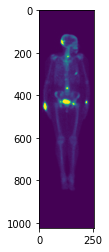

In [20]:
denoised = ndimage.median_filter(pixelArray, size=3);
plt.imshow(denoised);
#sigma_est = np.mean(estimate_sigma(pixelArray, multichannel=False))
#patch_kw = dict(patch_size=5,patch_distance=6,multichannel=False)

# denoised = denoise_nl_means(pixelArray, h=1.15 * sigma_est, fast_mode=False,**patch_kw)

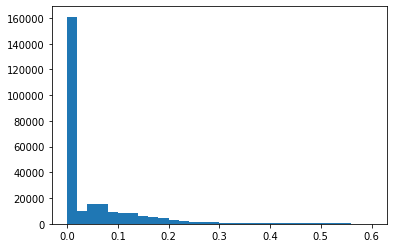

In [21]:
eq = exposure.equalize_adapthist(denoised);
plt.hist(eq.flat, bins=30, range=(0, 0.6));

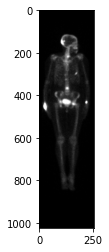

In [4]:
plt.imshow(eq, cmap='gray');

[0.10351562 0.43164062]


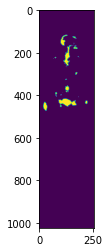

In [22]:
thresholds = threshold_multiotsu(eq, 3);
print(thresholds);
regions = np.digitize(eq, bins=thresholds);
bone = (regions == 1);
met = (regions == 2);
#plt.imshow(met);
#plt.imshow(bone);

segmented = np.zeros(eq.shape, dtype=np.float);
segmented[met] = eq[met];
plt.imshow(met);

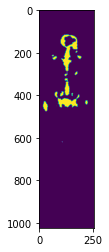

In [31]:
markers = np.zeros(eq.shape, dtype=np.uint);
markers[(eq < 0.1)] = 1;
markers[(eq > 0.1) & (eq < 0.25)] = 2;
markers[(eq >= 0.3)] = 3;

labels = random_walker(eq, markers, beta=10, mode='bf');
bone = (labels == 2);
met = (labels == 3);
#plt.imshow(met);
#plt.imshow(bone);

segmented = np.zeros(eq.shape, dtype=np.float);
segmented[met] = eq[met];
plt.imshow(met);

In [14]:
from skimage.color import label2rgb;
imgLabeled = measure.label(regions == 2, connectivity=eq.ndim);
#imageLabelOverlay = label2rgb(imgLabeled, image=eq);
# plt.imshow(imageLabelOverlay);
# cv2.imshow('labeld', imageLabelOverlay);
# cv2.waitKey(0);
# cv2.destroyAllWindows();

props = measure.regionprops_table(imgLabeled, eq, properties=['area', 'label', 'centroid']);

import pandas as pd;
data = pd.DataFrame(props);
print(data);

    area  label  centroid-0  centroid-1
0    595      1  143.225210  111.611765
1     86      2  127.895349  164.430233
2      5      3  155.400000  162.200000
3   1191      4  217.938707  131.401343
4      1      5  164.000000  151.000000
5      2      6  164.000000  159.500000
6      1      7  165.000000  156.000000
7      5      8  166.000000  167.400000
8      1      9  166.000000  150.000000
9      5     10  167.600000  153.200000
10   142     11  176.485915  169.084507
11     1     12  168.000000  150.000000
12     3     13  183.666667  131.333333
13     1     14  196.000000  128.000000
14     5     15  199.800000  124.600000
15     9     16  218.000000  182.333333
16    23     17  222.826087   76.043478
17     1     18  223.000000  186.000000
18     2     19  227.500000   68.000000
19     8     20  238.750000  141.625000
20     1     21  242.000000  141.000000
21     3     22  251.000000  119.000000
22     3     23  264.000000  125.666667
23     1     24  268.000000  129.000000


In [35]:
edge_roberts = roberts(segmented);
edge_sobel = sobel(segmented);
edge_scharr = scharr(segmented);
edge_prewitt = prewitt(segmented);
#cv2.imshow('roberts', edge_roberts);
#cv2.imshow('sobel', edge_sobel);
#cv2.imshow('sobel', edge_sobel);
#cv2.imshow('scharr', edge_scharr);
#cv2.imshow('prewitt', edge_prewitt);
#cv2.waitKey(0);
plt.imsave('./sobel.png',edge_sobel, cmap='gray');

In [45]:
edged = cv2.imread('./sobel.png', 0);
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_NONE);
colored = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)
cv2.drawContours(colored, contours, -1, (0,255,0), 1);
cv2.imshow('contours', colored);
cv2.waitKey(0);
print(len(contours));
cv2.destroyAllWindows();

20


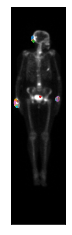

In [28]:
contours = measure.find_contours(edge_sobel);

fig, ax = plt.subplots()
ax.imshow(eq, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
cv2.destroyAllWindows();

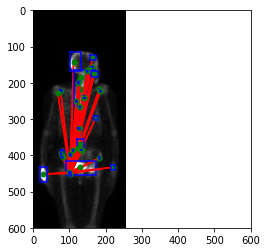

In [18]:
import math;

fig, ax = plt.subplots()
ax.imshow(eq, cmap=plt.cm.gray)

imgLabeled = measure.label(regions == 2, connectivity=eq.ndim);
regionsProps = measure.regionprops(imgLabeled)

for props in regionsProps:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

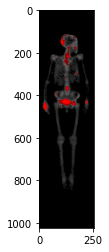

In [46]:
false_colors = np.zeros((rows, cols, 3), dtype=np.uint8);
for i in range(rows):
    for j in range(cols):
        if met[i,j]:
            false_colors[i,j] = (eq[i,j] * 255, 0, 0);
        if bone[i,j]:
            intensity = eq[i,j] * 255;
            false_colors[i,j] = (intensity, intensity, intensity);
plt.imshow(false_colors);

In [48]:
cv2.imshow('denoised and equalized', eq);
cv2.imshow('segmented', segmented);
cv2.imshow('false colors', cv2.cvtColor(false_colors, cv2.COLOR_RGB2BGR)); 
cv2.imshow('org', pixelArray);
cv2.waitKey(0);
cv2.destroyAllWindows();